# 1. Load MoonBoard Problem Data

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import copy
from GraphFunctions import *

In [2]:
#Data is taken from https://github.com/jrchang612/MoonBoardRNN
raw_data_path = 'moonGen_scrape_2016_final'
with open(raw_data_path, 'rb') as f:
    MoonBoard_2016_raw = pickle.load(f)
    
#Make holds list of numpy arrays
for key, problem in MoonBoard_2016_raw.items():
    problem['start'] = [np.array(el) for el in problem['start']]
    problem['mid'] = [np.array(el) for el in problem['mid']]
    problem['end'] = [np.array(el) for el in problem['end']]
    
    if len(problem['start']) > 2: #Some problems were transcribed weirdly and have many repeating holds
        problem['start'] = list(np.unique(np.array(problem['start']), axis = 0))
        problem['mid'] = list(np.unique(np.array(problem['mid']), axis = 0))
        problem['end'] = list(np.unique(np.array(problem['end']), axis = 0))

Create a list of problems than have been repeated at least 5 times. Augment the data by creating left-right mirrored versions of each of these climbs, which should have the same difficulty. 

In [3]:
problem_list = []
for key, problem in MoonBoard_2016_raw.items():
    if grade_to_class[problem['grade']] > 0.5 and grade_to_class[problem['grade']] < 10.5 and problem['repeats'] >= 1 and len(problem['start']) <= 2: #<9.5 make V10
        problem['mirrored'] = False
        problem_list += [problem]

        mirrored_problem = copy.deepcopy(problem)
        mirrored_problem['mirrored'] = True
        mirrored_problem['start'] = [np.array([1, -1])*(np.array([10, 0]) - el) for el in mirrored_problem['start']]
        mirrored_problem['mid'] = [np.array([1, -1])*(np.array([10, 0]) - el) for el in mirrored_problem['mid']]
        mirrored_problem['end'] = [np.array([1, -1])*(np.array([10, 0]) - el) for el in mirrored_problem['end']]
        problem_list += [mirrored_problem]
        
print("There are %d climbs with difficulty between V4 and V11 that have been repeated at least once." %len(problem_list))

There are 50140 climbs with difficulty between V4 and V11 that have been repeated at least once.


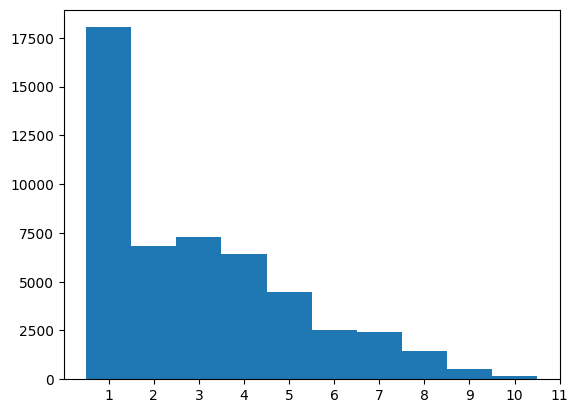

In [4]:
grades = np.zeros(len(problem_list))
for i in range(len(problem_list)):
    grades[i] = grade_to_class[problem_list[i]['grade']]

plt.hist(grades, bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5,10.5])
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.xlim([0, 11])
plt.xlabel("Climb difficulty class")
plt.ylabel("Number of climbs")
plt.title("Histogram of Climb Difficulties")
plt.show()

# 2. Load Moonnboard Hold Data

In [5]:
import pandas as pd

In [6]:
holdDiff = pd.read_csv("holdData.csv")
X_coord, Y_coord, LH, RH, Angle = holdDiff['X_coord'], holdDiff['Y_coord'], holdDiff['Difficulties LH'], holdDiff['Difficulties RH'], holdDiff['Angle']
holdDict = {}
for i in range(len(X_coord)):
    holdDict[(X_coord[i], Y_coord[i])] = {'LH': LH[i], 
                              'RH': RH[i],
                              'Angle': Angle[i]}

In [7]:
#For mirrored climbs, the hold parameters needs to be mirrored as well. 
holdDictMirror = {}
for key, el in holdDict.items():
    holdDictMirror[(10-key[0], key[1])] = {'LH': el['RH'],
                                        'RH': el['LH'],
                                        'Angle': -el['Angle']}

# 3. Make Problems Into Graph

Each problem on the moonboard is defined by a set of holds. The position of a climber, while climbing, can be defined by the position of their left hand and their right hand. From any position, they can move either their left or right hand. I create a graph in which each position, defined by a unique left hand and right hand pair, is a node. Each position, or node, is connected to every other position that requires moving only one hand. The edge value of the connections will later be learned and computed using a MLP model; by default they are initialized to zero. The problemGraph object is equiped to compute the optimal sequence given its edge values.

Initalizing the graphs takes a few minutes because it requires enumerating every possible move for every problem.

In [8]:
graph_list = []
for problem in problem_list:
    if problem['mirrored'] == False:
        graph_list += [problemGraph(problem, holdDict)]
    else:
        graph_list += [problemGraph(problem, holdDictMirror)]

# 4. Train the Model

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn import metrics
from sklearn.model_selection import train_test_split

In [10]:
class SimpleModel(torch.nn.Module):
    def __init__(self, input_size = 18, num_layers = 3, hidden = 20):
        super(SimpleModel, self).__init__()
        self.relu = torch.nn.ReLU()
        self.lrelu = torch.nn.LeakyReLU(negative_slope=0.0001)

        self.linear_layers = nn.ModuleList()
        self.linear_layers.append(torch.nn.Linear(input_size, hidden))

        for i in range(num_layers):
            self.linear_layers.append(torch.nn.Linear(hidden, hidden))
            
        self.linear_layers.append(torch.nn.Linear(hidden, 100))
        self.linear_layers.append(torch.nn.Linear(100, 10))
        self.linear_layers.append(torch.nn.Linear(10, 1))

    def forward(self, x, masks):

        for i in range(len(self.linear_layers)-1):
            linear = self.linear_layers[i]
            x = (linear(x).permute(2, 0 ,1)*masks).permute(1,2,0)
            x = self.lrelu(x)

        x = (self.linear_layers[-1](x).permute(2, 0 ,1)*masks).permute(1,2,0)
        x = self.relu(x)
        return x

In [11]:
n_resequence = 30 #Number of time to recalculate the optimal sequences for each climb
n_epochs = 100 #Number of training epoch for each set of optimal sequences
batch_size = 256 #The batch size during training

torch.manual_seed(15) #Set the seed for initializing the model for consistency, but does not really matter
model = SimpleModel(input_size = 18, hidden = 50, num_layers = 3).to(device) #Create the model
optimizer = optim.Adam(model.parameters(), lr= 1e-5, weight_decay= 1) #Create the optimizer with learning rate 1e-5 and L2 regularization constant of 1
loss_fn = nn.MSELoss(reduction = 'mean')  # L2 loss

printModelSummary(model)

SimpleModel(
  (relu): ReLU()
  (lrelu): LeakyReLU(negative_slope=0.0001)
  (linear_layers): ModuleList(
    (0): Linear(in_features=18, out_features=50, bias=True)
    (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=100, bias=True)
    (5): Linear(in_features=100, out_features=10, bias=True)
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

Total numer of trainable parameters is 14721.


In [12]:
#Define a function that takes an numpy array of moves and outputs a numpy array of difficulty scores using the model
def calc_move_difficulty(moves):
    X = torch.from_numpy(moves).type(torch.FloatTensor).to(device)
    return model(X, torch.Tensor([1.]).to(device)).cpu().detach().numpy().squeeze()

#Define a function to calculate the accuracy of the predictions made by the model
def calculate_accuracy(Y_pred, Y_true):
    #Y_pred is the sum of the difficulty score of all of the moves on a climb
    #Y_true is the target difficulty score of the sum of the moves on a climb
    
    y_pred = get_class(Y_pred) #Convert from difficulty score to problem difficulty class
    y_true = get_class(Y_true) #Convert from difficulty score to problem difficulty class

    #Calculate the accuracy
    acc = np.sum(y_pred == y_true)/len(y_pred) #Calculate the accuracy

    #Calculate the accuracy plus or minus one
    y_pred_p1, y_pred_m1 = y_pred + 1, y_pred - 1
    acc_pm1 = (np.sum(y_pred == y_true) + np.sum(y_pred_p1 == y_true) + np.sum(y_pred_m1 == y_true))/len(y_pred)

    #Repeat the calculations, but this time, instead of using font grades use the Heuco V grade system. 
    v_pred = convert_class_to_V_scale(y_pred)
    v_true = convert_class_to_V_scale(y_true)
    
    #Calculate the accuracy of v grades
    acc_v = np.sum(v_pred == v_true)/len(Yp)

    #Calculate the accuracy of v grades plus or minus one
    v_pred_p1, v_pred_m1 = v_pred + 1, v_pred - 1
    acc_v_pm1 = (np.sum(v_pred == v_true) + np.sum(v_pred_p1 == v_true) + np.sum(v_pred_m1 == v_true))/len(Yp)
    
    return acc, acc_pm1, acc_v, acc_v_pm1

def get_class(Y):
    return np.round(2*(np.log2(Y.cpu().detach().numpy() + 1e-20)-2))

def convert_class_to_V_scale(Y):
    #In the V grades, 6C and 6C+ both correspond to a single class called V5.
    #Similarly, 7B and 7B+ both corresponds to a single class called V8. 
    #Paper online report the accuracy of their predictions using V grades. 
    V = np.zeros_like(Y)

    for i in range(len(Y)):
        if Y[i] <= 2:
            V[i] = Y[i]
        elif Y[i] <= 6:
            V[i] = Y[i]-1
        else:
            V[i] = Y[i]-2

    return V

In [13]:
history_list = []

In [ ]:
for j in range(n_resequence):
    
    #Compute the edge values of each graph using the update move difficulty model and them find the optimal path to traverse it
    longest_sequence = 0
    for graph in graph_list:
        graph.compute_edges(calc_move_difficulty)
        graph.optimize_sequence()
        if len(graph.optimal_seq) > longest_sequence:
            longest_sequence = len(graph.optimal_seq)

    print("For resequence %d the longest sequence length is %d"%(j, longest_sequence))

    X = [] #Sequence
    L = [] #Unpadded sequence length
    Y = [] #Grade class
    
    for graph in graph_list:
        sequence = graph.optimal_moves
        L.append(len(sequence))
        sequence = np.pad(sequence, ((0, longest_sequence-len(sequence)), (0,0)))
        X.append(sequence)
        Y.append(2**(2+grade_to_class[graph.problem['grade']]/2))
    
    X_train, X_test, Y_train, Y_test, L_train, L_test = train_test_split(np.array(X), np.array(Y), np.array(L), test_size=0.2, random_state=42)
    
    Xt = torch.from_numpy(X_train).type(torch.FloatTensor).to(device)
    Yt = torch.from_numpy(Y_train).type(torch.FloatTensor).to(device)
    Lt = torch.from_numpy(L_train).type(torch.FloatTensor)
    Mask_t = create_mask(Lt, longest_sequence).to(device)
    
    Xtest = torch.from_numpy(X_test).type(torch.FloatTensor).to(device)
    Ytest = torch.from_numpy(Y_test).type(torch.FloatTensor).to(device)
    Ltest = torch.from_numpy(L_test).type(torch.FloatTensor)
    Mask_test = create_mask(Ltest, longest_sequence).to(device)
    
    history = {'loss': np.zeros(n_epochs), 
               'train accuracy': np.zeros(n_epochs),
               'train accuracy pm1': np.zeros(n_epochs),
               'train accuracy v': np.zeros(n_epochs),
               'train accuracy v pm1': np.zeros(n_epochs),
               'test loss': np.zeros(n_epochs), 
               'test accuracy': np.zeros(n_epochs), 
               'test accuracy pm1': np.zeros(n_epochs),
               'test accuracy v': np.zeros(n_epochs),
               'test accuracy v pm1': np.zeros(n_epochs)}
    
    for epoch in range(n_epochs):
        for i in range(0, len(Y)//batch_size):
            Yp = torch.sum(model(Xt[i*batch_size:(i+1)*batch_size], Mask_t[i*batch_size:(i+1)*batch_size]).squeeze(), axis = 1)
            loss = loss_fn(Yp, Yt[i*batch_size:(i+1)*batch_size]).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        Yp = torch.sum(model(Xt, Mask_t).squeeze(), axis = 1)
        
        loss = loss_fn(Yp, Yt).cpu().detach()
        history['loss'][epoch] = loss
        acc, acc_pm1, acc_v, acc_v_pm1 = calculate_accuracy(Yp, Yt)
        
        history['train accuracy'][epoch], history['train accuracy pm1'][epoch] = acc, acc_pm1
        history['train accuracy v'][epoch], history['train accuracy v pm1'][epoch] = acc_v, acc_v_pm1
        
        Yp = torch.sum(model(Xtest, Mask_test).squeeze(), axis = 1)

        test_loss = loss_fn(Yp, Ytest).cpu().detach()
        history['test loss'][epoch] = test_loss
        
        acc, acc_pm1, acc_v, acc_v_pm1 = calculate_accuracy(Yp, Ytest)
        history['test accuracy'][epoch], history['test accuracy pm1'][epoch] = acc, acc_pm1
        history['test accuracy v'][epoch], history['test accuracy v pm1'][epoch] = acc_v, acc_v_pm1
        
        if epoch%10 == 0:
            print(f'Finished epoch {epoch}, latest loss {loss}, latest test loss {test_loss}') #, latest accuracy {100*train_acc:.2f}%
    
    print(f'Finished epoch {epoch}, latest loss {loss}, latest test loss {test_loss}')

    history_list += [history]

#Optimize the sequences one last time with the final model
for graph in graph_list:
    graph.compute_edges(calc_move_difficulty)
    graph.optimize_sequence()

print("Done!")

For resequence 0 the longest sequence length is 3
Finished epoch 0, latest loss 510.24749755859375, latest test loss 504.026123046875
Finished epoch 10, latest loss 267.9197692871094, latest test loss 262.52020263671875
Finished epoch 20, latest loss 254.4644775390625, latest test loss 249.112060546875
Finished epoch 30, latest loss 249.6663360595703, latest test loss 244.2780303955078
Finished epoch 40, latest loss 246.68545532226562, latest test loss 241.3055419921875
Finished epoch 50, latest loss 245.0055389404297, latest test loss 239.67172241210938
Finished epoch 60, latest loss 244.06053161621094, latest test loss 238.79464721679688
Finished epoch 70, latest loss 243.45114135742188, latest test loss 238.251953125
Finished epoch 80, latest loss 242.9986572265625, latest test loss 237.8638153076172
Finished epoch 90, latest loss 242.64639282226562, latest test loss 237.5670166015625
Finished epoch 99, latest loss 242.37271118164062, latest test loss 237.33860778808594
For resequen

# 5. Plot Convergence Properties

In [ ]:
reseq = np.arange(len(history_list))
loss_test, loss_train, acc_test, acc_test_pm1, acc_train, acc_train_pm1 = np.zeros(len(reseq)), np.zeros(len(reseq)), np.zeros(len(reseq)), np.zeros(len(reseq)), np.zeros(len(reseq)), np.zeros(len(reseq)) 

for i in range(len(history_list)):
    hist = history_list[i]
    loss_train[i] = hist['loss'][-1]
    loss_test[i] = hist['test loss'][-1]
    acc_test[i] = hist['test accuracy'][-1]
    acc_test_pm1[i] = hist['test accuracy pm1'][-1]
    acc_train[i] = hist['train accuracy'][-1]
    acc_train_pm1[i] = hist['train accuracy pm1'][-1]

In [ ]:
plt1 = plt.subplot(311)
plt2 = plt.subplot(312)
plt3 = plt.subplot(313)

plt1.plot(reseq, loss_train)
plt1.plot(reseq, loss_test)

plt2.plot(reseq, acc_train)
plt2.plot(reseq, acc_test)

plt3.plot(reseq, acc_train_pm1)
plt3.plot(reseq, acc_test_pm1)

plt.show()

# 6. Evaluating Determined Sequences

Does a reasonable job predicting beta! A couple examples are shown below. Overall, given that no physical insight was actually input other than the feature engineering and 

In [ ]:
#Predicts a reasonable sequence
problem_index = 0
print(graph_list[problem_index].problem['url'])
print(graph_list[problem_index].optimal_seq)

In [ ]:
#Predicts a reasonable sequence
problem_index = 25164
print(graph_list[problem_index].problem['url'])
print(graph_list[problem_index].optimal_seq)

In [ ]:
#Predicts a reasonable sequence
problem_index = 37046
print(graph_list[problem_index].problem['url'])
print(graph_list[problem_index].optimal_seq)

In [ ]:
#Predicts a reasonable sequence, though matching hands on (4,7) is unnecessary
problem_index = 40550
print(graph_list[problem_index].problem['url'])
print(graph_list[problem_index].optimal_seq)

In [ ]:
#Fails to predict a reasonable sequence
problem_index = 41780
print(graph_list[problem_index].problem['url'])
print(graph_list[problem_index].optimal_seq)

In [ ]:
#Fails to predict a reasonable sequence, though predicts the same "incorrect" sequence as in the previously analyzed problem. Suggests that more data to learn the patterns better may fix the issue. 
problem_index = 23608
print(graph_list[problem_index].problem['url'])
print(graph_list[problem_index].optimal_seq)

In [ ]:
#Predicts a reasonable sequence
problem_index = 33798
print(graph_list[problem_index].problem['url'])
print(graph_list[problem_index].optimal_seq)

In [ ]:
#Predicts a reasonable sequence, though the last move is likely not the easiest way. 
problem_index = 30200
print(graph_list[problem_index].problem['url'])
print(graph_list[problem_index].optimal_seq)

# 7. Classification Accuracy Analysis

First check the accuracy

In [ ]:
Yp = torch.sum(model(Xt, Mask_t).squeeze(), axis = 1)

_, _, acc_v, acc_v_pm1 = calculate_accuracy(Yp, Yt)

print("Train V accuracy: ", acc_v)
print("Train V accuracy pm1: ", acc_v_pm1)

print("\n-------------------------------------------------\n")

Yp = torch.sum(model(Xtest, Mask_test).squeeze(), axis = 1)

_, _, acc_v, acc_v_pm1 = calculate_accuracy(Yp, Ytest)

print("Test V accuracy: ", acc_v)
print("Test V accuracy pm1: ", acc_v_pm1)

In [ ]:
Yp1 = torch.sum(model(Xt, Mask_t).squeeze(), axis = 1)
Yp2 = torch.sum(model(Xtest, Mask_test).squeeze(), axis = 1)

predicted = np.concatenate((convert_class_to_V_scale(get_class(Yp1)),convert_class_to_V_scale(get_class(Yp2))))
actual = np.concatenate((convert_class_to_V_scale(get_class(Yt)),convert_class_to_V_scale(get_class(Ytest))))
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12']) #
cm_display.plot()
plt.show()